In [1]:
import os
from thermof.read import read_log, read_thermo
import numpy as np
from wham import *
import matplotlib.pyplot as plt
%matplotlib inline

In [66]:
SCAN = 'scan3-y'
DRX = 'y'
hist_min, hist_max = 21, 26

In [67]:
thermo_headers = 'Step Temp Press TotEng E_pair E_mol Fmax Fnorm c_C1[1] c_C1[2] c_C1[3]'
thermo_keys = ['step', 'temp', 'press', 'etotal', 'epair', 'emol', 'fmax', 'fnorm', 'x', 'y', 'z']

In [68]:
scandir = os.path.join('data', SCAN)
scanlist = [os.path.join(scandir, i) for i in os.listdir(scandir)]
whamdir = os.path.abspath('wham')

### Write 1D WHAM time series files

In [69]:
start_pos = {}
histdata = {'x': [], 'xi': [], 'y': [], 'yi': []}
for simdir in scanlist:
    logfile = os.path.join(simdir, 'log.HtBDC_Cu110')
    try:
        simidx, xi, yi = [int(i) for i in os.path.basename(simdir).split('-')]
        thermo_data = read_log(logfile, headers=thermo_headers)
        thermo = read_thermo(thermo_data, headers=thermo_keys)[0]
        # Write time series files
        timeseriesfile = os.path.join(whamdir, SCAN, 'ts', '%i.dat' % (simidx))
        # SHIFT TIME AND COORDINATES -----------------------------------------------------------------------------
        time = timesteps_to_time(thermo['step'][5:], dt=1, conversion=1e-3, shift=25)  # femtosecond -> picosecond
        coordinates = thermo[DRX][5:]
        # --------------------------------------------------------------------------------------------------------
        write_timeseries_file(timeseriesfile, time, coordinates)
        # Record starting position (min energy pos)
        start_pos['%i' % (simidx)] = coordinates[0]
        histdata[DRX].append(coordinates)
        histdata['%si' % DRX].append(simidx)
    except Exception as e:
        print(e, logfile)

### Write 1D WHAM input files

In [70]:
npoints = len(scanlist)
tsfiles, mins = [], []
for i in range(npoints):
    tsfiles.append(os.path.join(whamdir, SCAN, 'ts', '%i.dat' % (i)))
    mins.append(start_pos['%i' % (i)])
spring_k = [10.0] * npoints
datafile = os.path.join(whamdir, SCAN, '%s.in' % (SCAN))
write_data_file(datafile, tsfiles, mins, spring_k)

### Run 1D WHAM

In [71]:
bin_size = 0.1
num_bins = np.ceil((hist_max - hist_min) / bin_size)
tolerance = 1e-5
temperature = 200
numpad = 0
wham_exec = '/home/kutay/Documents/Research/Software/wham/wham/wham'
outfile = os.path.join(whamdir, SCAN, '%s.out' % (SCAN))

In [72]:
wham_args = [wham_exec, hist_min, hist_max, num_bins, tolerance, temperature, numpad, datafile, outfile]
data = run_wham(wham_args, verbose=False)

### Plot energy barrier

In [74]:
# xlim = (21.5, 26)
xlim = (22.5, 26)

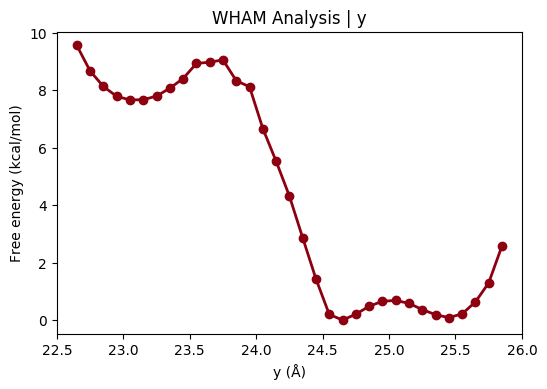

In [75]:
plt.plot(data['coor'], data['free'], '-o', c='xkcd:crimson', lw=2, markersize=6)
plt.xlim(xlim)
plt.xlabel('%s (Å)' % DRX)
plt.ylabel('Free energy (kcal/mol)')
plt.title('WHAM Analysis | %s' % DRX)

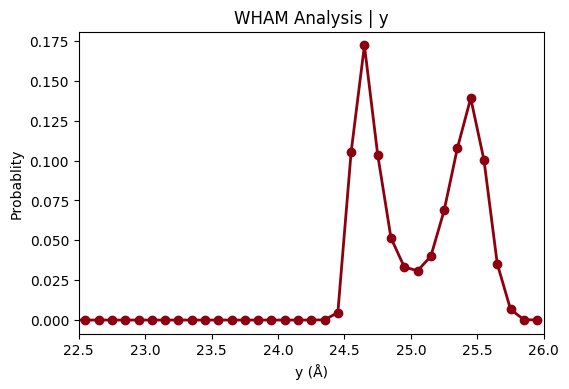

In [76]:
plt.plot(data['coor'], data['prob'], '-o', c='xkcd:crimson', lw=2, markersize=6)
plt.xlim(xlim)
plt.xlabel('%s (Å)' % DRX)
plt.ylabel('Probablity')
plt.title('WHAM Analysis | %s' % DRX)

### Distance histograms

In [64]:
from scipy.stats import norm
import matplotlib.mlab as mlab


def plot_hist(data, bins=50, color='b', linestyle='k', alpha=0.7, lw=1.5):
    (mu, sigma) = norm.fit(data)
    # the histogram of the data
    n, bins, patches = plt.hist(data, bins, normed=1, facecolor=color, alpha=alpha)
    # add a 'best fit' line
    y = mlab.normpdf(bins, mu, sigma)
    l = plt.plot(bins, y, linestyle, linewidth=lw)
    # plt.scatter(data[0], max(y), c='k')

(21.5, 26)

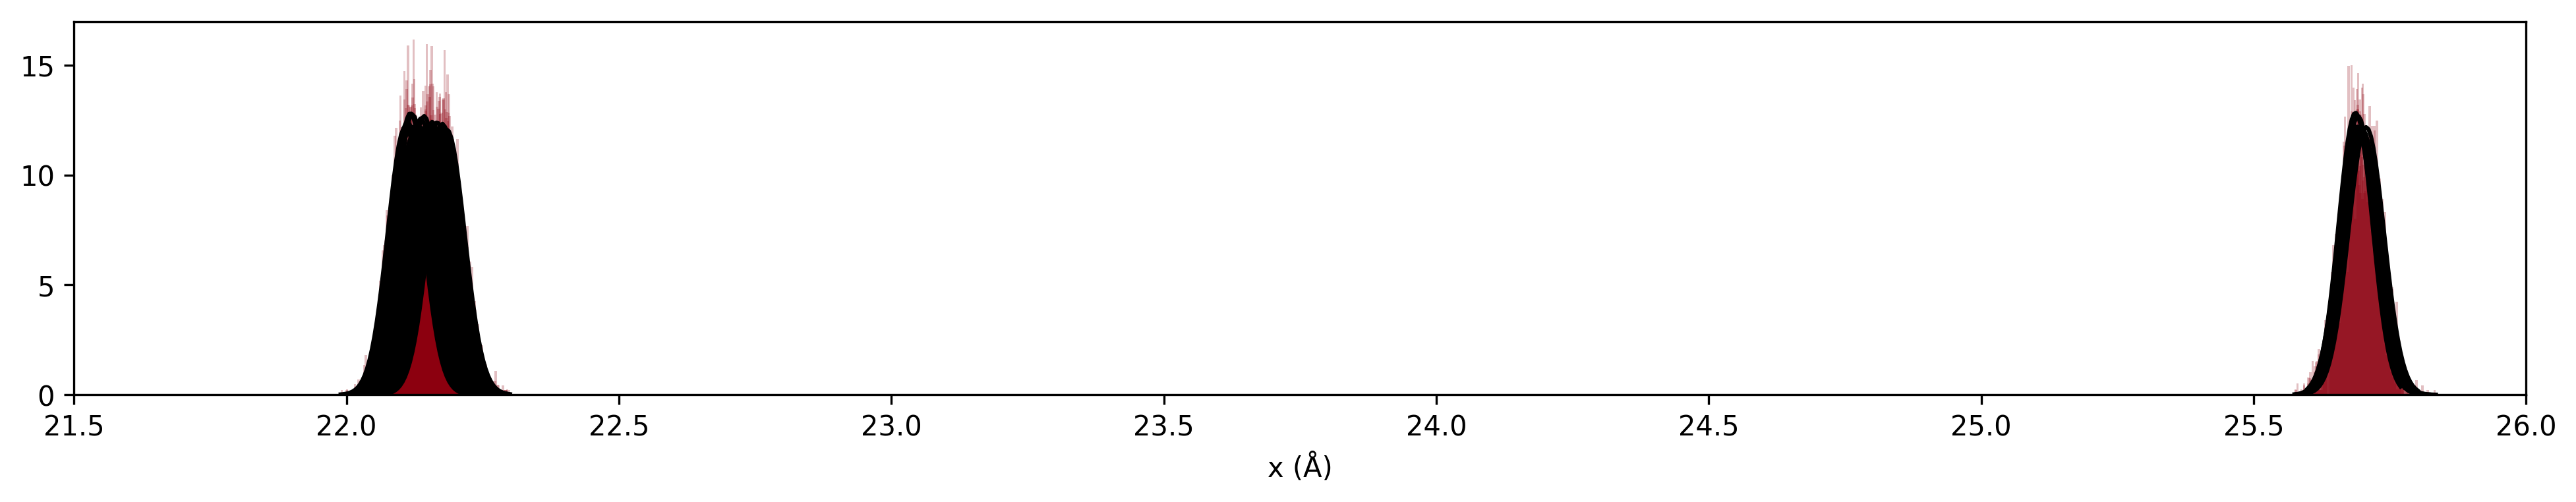

In [65]:
fig = plt.figure(figsize=(16, 2.5), dpi=300)
for i in range(npoints):
    idx = histdata['%si' % DRX].index(i)
    plot_hist(histdata['%s' % DRX][idx], alpha=0.25, color='xkcd:crimson')
plt.xlabel('%s (Å)' % DRX)
# plt.yticks([0, 0.5, 1.0, 1.5])
plt.xlim(xlim)
# plt.ylim(0, 1.5)

### Calculate rate

$k_{A \rightarrow B} = \kappa {\sqrt{ \dfrac{1}{2 \pi M \beta}}} \dfrac{ e^{- \beta F(q^*)} } { \int e^{- \beta F(q)}dq }$


In [2]:
from angstrom import Molecule

In [3]:
htbdc = Molecule(read='/home/kutay/Documents/git/Nanocar/molecules/surface-diffusion/opt/HtBDC.xyz')

In [4]:
htbdc.get_molecular_weight()

787.166039999999

Max: 13.01
area = 81499.9530318
area = 81499.9530322


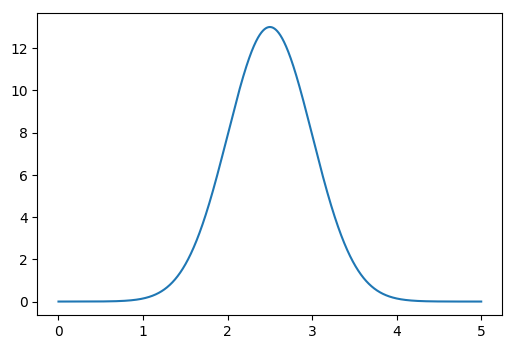

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import simps
from numpy import trapz

# Plot between -10 and 10 with .001 steps.
x_axis = np.arange(0, 5, 0.001)
y_axis = norm.pdf(x_axis, 2.5, .5) * 16.3
plt.plot(x_axis, y_axis)
print('Max: %.2f' % max(y_axis))
# Compute the area using the composite trapezoidal rule.
area = trapz(y_axis, dx=5)
print("area =", area)
# Compute the area using the composite Simpson's rule.
area = simps(y_axis, dx=5)
print("area =", area)

In [69]:
 np.exp(-beta * fq_area)

0.0

In [68]:
kappa = 1
T = 200  # K
MW = htbdc.get_molecular_weight()
kb = 3.29982916e-27  # kcal / K
kb = 0.0019872041   # kcal / mol.K
beta = 1 / (kb * T)
fq_star = 13  #  kcal/mol
fq_area = trapz(np.exp(-beta * y_axis), dx=5)

k_AB = kappa * np.sqrt(1 / (2 * np.pi * MW * beta)) * np.exp(-beta * fq_star) / np.exp(-beta * fq_area)
print(k_AB)

inf


/home/kutay/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in double_scalars


In [65]:
lamda = 6
D_s = 1 / 2 * k_AB * lamda
print(D_s)

0.026892698376
